<a href="https://colab.research.google.com/github/Shreenidhi-Kovai-Sivabalan/Accurate-Energy-Demand-Prediction/blob/main/BaselineModels.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Appendix A
# Accurate Energy Demand Prediction for Smart Cities using Deep Learning
Project Code

Shreenidhi Kovai Sivabalan

Date of Submission: Oct 1, 2025

# A3. Baseline Models

In [ ]:
# Mounting to Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Importing necessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import time

Importing the saved data that has been prepared.

In [ ]:
filepath1 = '/content/drive/MyDrive/dissertation/data/data_minute.csv'
df_minute = pd.read_csv(filepath1)
df_minute.set_index('Datetime', inplace=True)
#df_minute.head(2)

In [ ]:
filepath2 = '/content/drive/MyDrive/dissertation/data/data_hourly.csv'
df_hourly = pd.read_csv(filepath2)
df_hourly.set_index('Datetime', inplace=True)
#df_hourly.head(2)

In [ ]:
filepath3 = '/content/drive/MyDrive/dissertation/data/data_daily.csv'
df_daily = pd.read_csv(filepath3)
df_daily.set_index('Datetime', inplace=True)
#df_daily.head(2)

Functions of model evaluation

In [ ]:
# Function for evaluating the models' performances

def evaluate_model(y_true, y_pred, model_name, freq, execution_time):
  mse = mean_squared_error(y_true, y_pred)
  mae = mean_absolute_error(y_true, y_pred)
  rmse = np.sqrt(mse)
  r2 = r2_score(y_true, y_pred)
  print(f"\n{model_name} ({freq}) Results:")
  print(f"MSE: {mse:.4f}")
  print(f"MAE: {mae:.4f}")
  print(f"RMSE: {rmse:.4f}")
  print(f"R2 Score: {r2:.4f}")
  print(f"Execution Time: {execution_time:.4f} seconds")
  return {"Model": model_name, "Frequency": freq, "MSE": mse, "MAE": mae, "RMSE": rmse, "R2": r2, "Execution Time": execution_time}

In [ ]:
# Function for plotting actual vs. predicted
def plot_actual_vs_pred(y_true, y_pred, freq):
  plt.figure(figsize=(12, 6))
  plt.plot(y_true.index, y_true, label="Actual", color='black')
  plt.plot(y_test.index, y_pred, label="Predicted", color='blue', alpha=0.7)
  plt.title(f"Energy Demand ({freq}): Actual Vs. Predicted")
  plt.xlabel("Time")
  plt.ylabel("Global Active Power")
  plt.legend()
  # Improve x-axis display
  plt.xticks(rotation=45)
  plt.gca().xaxis.set_major_locator(plt.MaxNLocator(nbins=10)) # Adjust number of ticks
  plt.tight_layout()
  plt.show()

In [ ]:
# Function for plotting residual distribution
def plot_residuals(y_true, y_pred, freq):
  residuals = y_true - y_pred.flatten()

  plt.figure(figsize=(12, 6))
  sns.histplot(residuals, kde=True, color='red', stat='density', bins=50)
  plt.title(f"Residual Distribution ({freq})")
  plt.xlabel("Prediction Error")
  plt.ylabel("Density")
  plt.legend()
  plt.show()

In [ ]:
# Function for plotting seasonal pattern comparison
# period = no. of steps in one daily/weekly cycle -> 60/1440 for minutes, 24/168 for hours, 7 for days
def plot_seasonal_patterns(y_true, y_pred, period, freq):
  # Ensure y_pred is a pandas Series with the same index as y_true
  if isinstance(y_pred, np.ndarray):
      y_pred = pd.Series(y_pred.flatten(), index=y_true.index)

  avg_true = [y_true[i::period].mean() for i in range(period)]
  avg_pred = [y_pred[i::period].mean() for i in range(period)]

  plt.figure(figsize=(12, 6))
  plt.plot(avg_true, label="Actual", color='black', marker='o')
  plt.plot(avg_pred, label="Predicted", color='orange', marker='x')
  plt.title(f"Average Seasonal Pattern ({freq} for {period} period)")
  plt.xlabel(f"Time within Cycle (Period = {period})")
  plt.ylabel("Global Active Power")
  plt.legend()
  # Improve x-axis display
  plt.xticks(np.arange(0, period, max(1, period // 10))) # Adjust number of ticks
  plt.tight_layout()
  plt.show()

## Model Execution

**Preparing the data for model execution**

In [ ]:
target = 'Global_active_power'
features_min = df_minute.columns.tolist()
features_min.remove(target)
X_min = df_minute[features_min]
y_min = df_minute[target]

In [ ]:
features_hr = df_hourly.columns.tolist()
features_hr.remove(target)
X_hr = df_hourly[features_hr]
y_hr = df_hourly[target]

In [ ]:
features_dy = df_daily.columns.tolist()
features_dy.remove(target)
X_dy = df_daily[features_dy]
y_dy = df_daily[target]

In [ ]:
# Select 10% of the minute-level data chronologically
# 10% of the minute-level data was used.
# This is due to the scale of minute data.

split_idx = int(len(X_min) * 0.1)
X_min_sub = X_min.iloc[:split_idx]
y_min_sub = y_min.iloc[:split_idx]
print(f"Subsample size: {X_min_sub.shape[0]} rows")

Subsample size: 206517 rows


In [ ]:
# Train/Test split -- 80/20 time-based split
split_idx1 = int(len(X_min_sub) * 0.8) # Use the subsampled data
X_min_train, X_min_test = X_min_sub.iloc[:split_idx1], X_min_sub.iloc[split_idx1:]
y_min_train, y_min_test = y_min_sub.iloc[:split_idx1], y_min_sub.iloc[split_idx1:]

split_idx2 = int(len(X_hr) * 0.8)
X_hr_train, X_hr_test = X_hr.iloc[:split_idx2], X_hr.iloc[split_idx2:]
y_hr_train, y_hr_test = y_hr.iloc[:split_idx2], y_hr.iloc[split_idx2:]

split_idx3 = int(len(X_dy) * 0.8)
X_dy_train, X_dy_test = X_dy.iloc[:split_idx3], X_dy.iloc[split_idx3:]
y_dy_train, y_dy_test = y_dy.iloc[:split_idx3], y_dy.iloc[split_idx3:]

In [ ]:
# train and test split for the models -- can  be switched between min, hr, dy
# This makes experimetation easier.

X_train, X_test = X_dy_train, X_dy_test
y_train, y_test = y_dy_train, y_dy_test
freq = "Daily"

In [ ]:
results = []

**Naive Forecast**

In [ ]:
# Naive -- last observed value
start_time = time.time()
y_pred_naive = y_test.shift(1).fillna(method="bfill")
end_time = time.time()
naive_time = end_time - start_time

results.append(evaluate_model(y_test, y_pred_naive, "Naive Forecast", freq, naive_time))


Naive Forecast (Daily) Results:
MSE: 0.0084
MAE: 0.0653
RMSE: 0.0917
R2 Score: 0.1776
Execution Time: 0.0005 seconds


**SARIMA**

In [ ]:
# SARIMA with simple order

# determining seasonal period based on which frequency data
seasonal_period = 7 if freq == "Daily" else (24 if freq == "Hourly" else 1440)
sarima_order = (2, 1, 2)
seasonal_order = (1, 1, 1, seasonal_period)

sarima_model = SARIMAX(y_train, order=sarima_order, seasonal_order=seasonal_order,
                       enforce_stationarity=False, enforce_invertibility=False)

start_time = time.time()
sarima_model_fit = sarima_model.fit()
y_pred_sarima = sarima_model_fit.forecast(steps=len(y_test))
end_time = time.time()
sarima_time = end_time - start_time

results.append(evaluate_model(y_test, y_pred_sarima, "SARIMA", freq, sarima_time))

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



SARIMA (Daily) Results:
MSE: 0.0662
MAE: 0.2316
RMSE: 0.2573
R2 Score: -5.4756
Execution Time: 3.3092 seconds


In [ ]:
# Residual Diagnostic - to check if it is modeling the energy demand properly or if it's missing structure
# This function was coded with the help of ChatGPT
# Prompt: can you help me code a function that would analyse the residuals of SARIMA model

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import scipy.stats as stats

def sarima_diagnostics(model_fit):
    residuals = model_fit.resid

    fig, axes = plt.subplots(2, 2, figsize=(12, 8))

    # Residuals over time
    axes[0, 0].plot(residuals)
    axes[0, 0].set_title("Residuals over Time")

    # Histogram + KDE of residuals
    sns.histplot(residuals, kde=True, ax=axes[0, 1])
    axes[0, 1].set_title("Residuals Distribution")

    # ACF plot
    plot_acf(residuals, lags=40, ax=axes[1, 0])
    axes[1, 0].set_title("ACF of Residuals")

    # Q-Q plot
    stats.probplot(residuals, dist="norm", plot=axes[1, 1])
    axes[1, 1].set_title("Q-Q Plot")

    plt.tight_layout()
    plt.show()

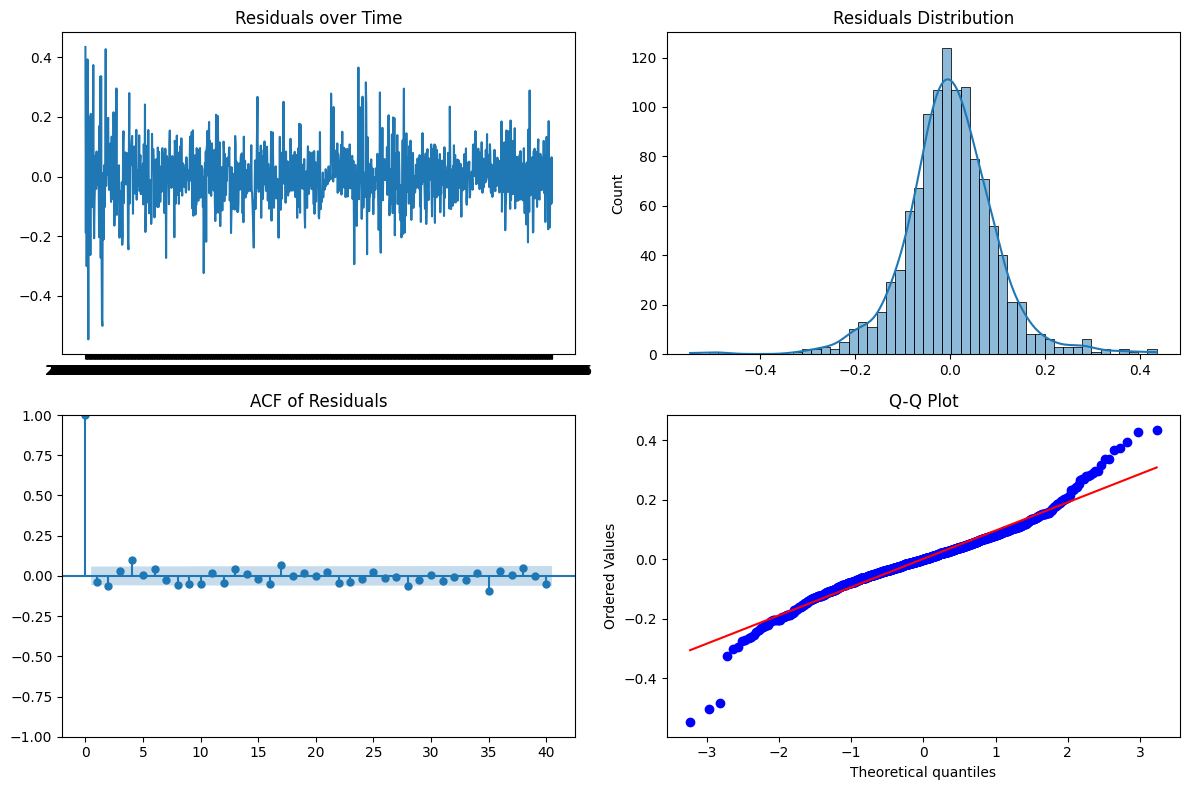

In [ ]:
sarima_diagnostics(sarima_model_fit)

**Holt-Winters**

In [ ]:
#Holt-Winters

# seasonal period depending on frequency
seasonal_period = 7 if freq == "Daily" else (24 if freq == "Hourly" else 1440)

hw_model = ExponentialSmoothing(y_train, trend="add", seasonal="add", seasonal_periods=seasonal_period)

start_time = time.time()
hw_model_fit = hw_model.fit(optimized=True)
y_pred_hw = hw_model_fit.forecast(len(y_test))
end_time = time.time()
hw_time = end_time - start_time

results.append(evaluate_model(y_test, y_pred_hw, "Holt-Winters", freq, hw_time))


Holt-Winters (Daily) Results:
MSE: 0.0216
MAE: 0.1180
RMSE: 0.1471
R2 Score: -1.1162
Execution Time: 0.1967 seconds


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


**Multiple Linear Regression**


In [ ]:
# Multiple Linear Regression
linreg_model = LinearRegression()

start_time = time.time()
linreg_model.fit(X_train, y_train)
y_pred_linreg = linreg_model.predict(X_test)
end_time = time.time()
linreg_time = end_time - start_time

results.append(evaluate_model(y_test, y_pred_linreg, "Multiple Linear Regression", freq, linreg_time))


Multiple Linear Regression (Daily) Results:
MSE: 0.0000
MAE: 0.0028
RMSE: 0.0037
R2 Score: 0.9987
Execution Time: 0.0063 seconds


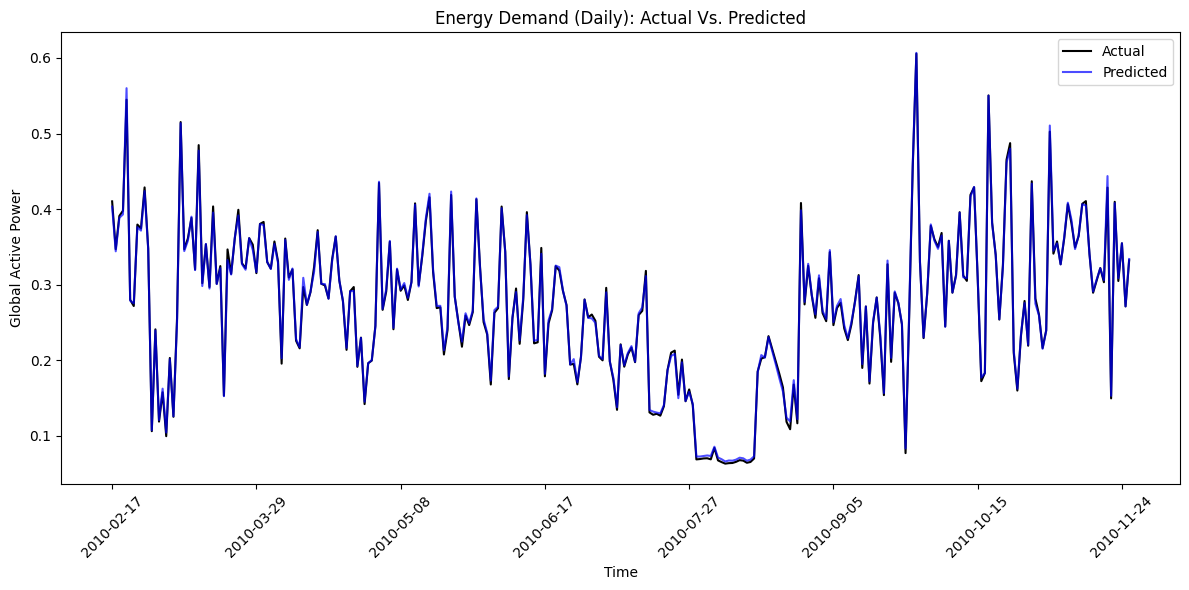

In [ ]:
plot_actual_vs_pred(y_test, y_pred_linreg, freq)

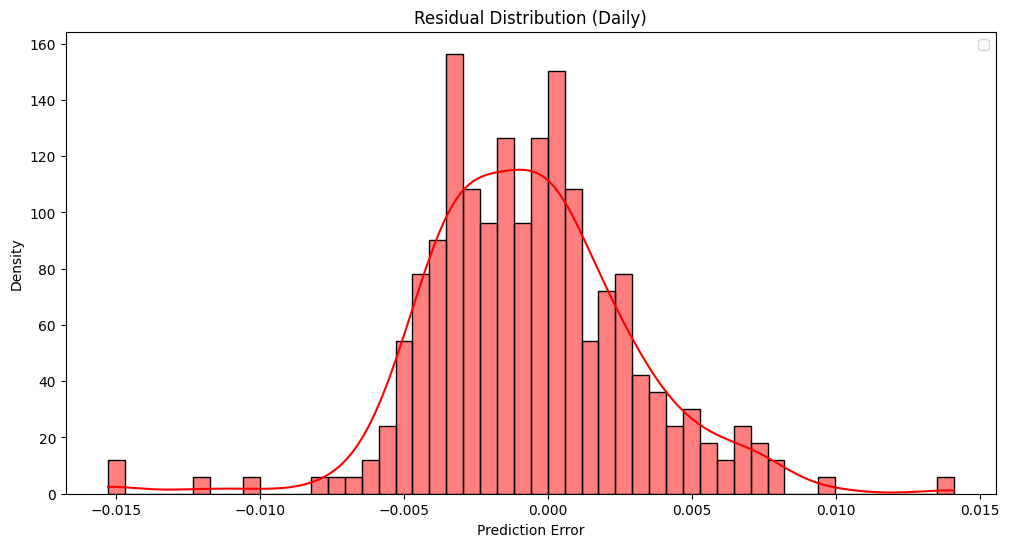

In [ ]:
plot_residuals(y_test, y_pred_linreg, freq)

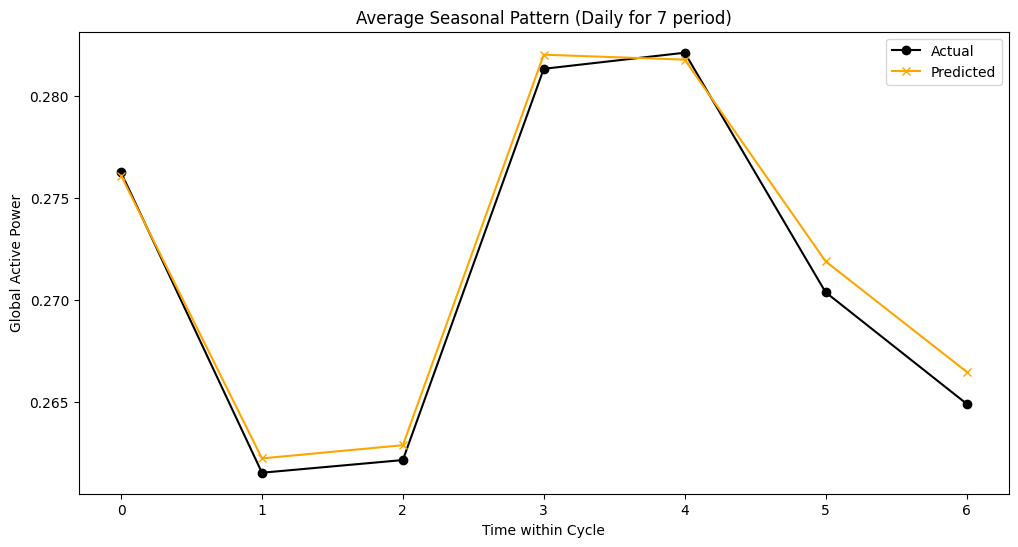

In [ ]:
plot_seasonal_patterns(y_test, y_pred_linreg, 7, freq)
#plot_seasonal_patterns(y_test, y_pred_linreg, 168, freq)

**Random Forest**

In [ ]:
#Random Forest Regressor

# the model was coded using simple, defaul parameters
rf_model = RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1)

start_time = time.time()
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
end_time = time.time()
rf_time = end_time - start_time

results.append(evaluate_model(y_test, y_pred_rf, "Random Forest Regressor", freq, rf_time))


Random Forest Regressor (Daily) Results:
MSE: 0.0000
MAE: 0.0041
RMSE: 0.0053
R2 Score: 0.9972
Execution Time: 0.6776 seconds


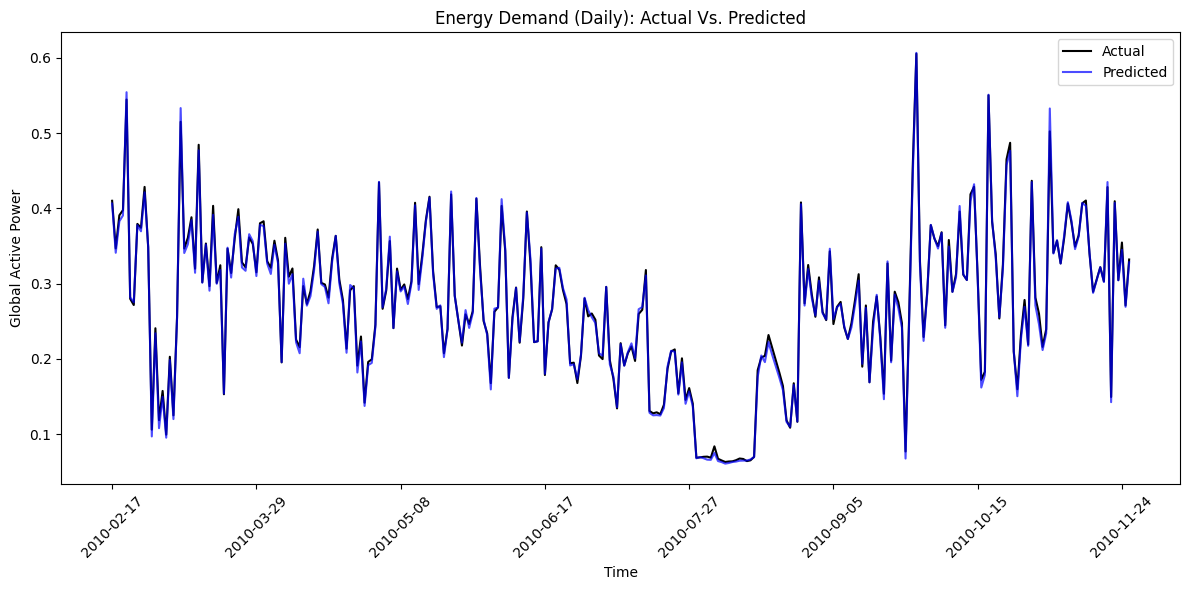

In [ ]:
plot_actual_vs_pred(y_test, y_pred_rf, freq)

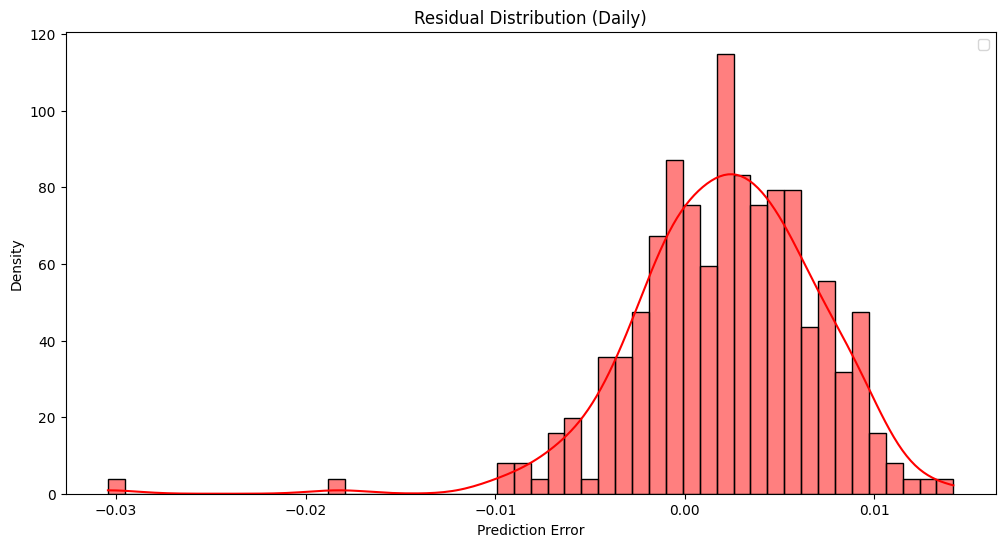

In [ ]:
plot_residuals(y_test, y_pred_rf, freq)

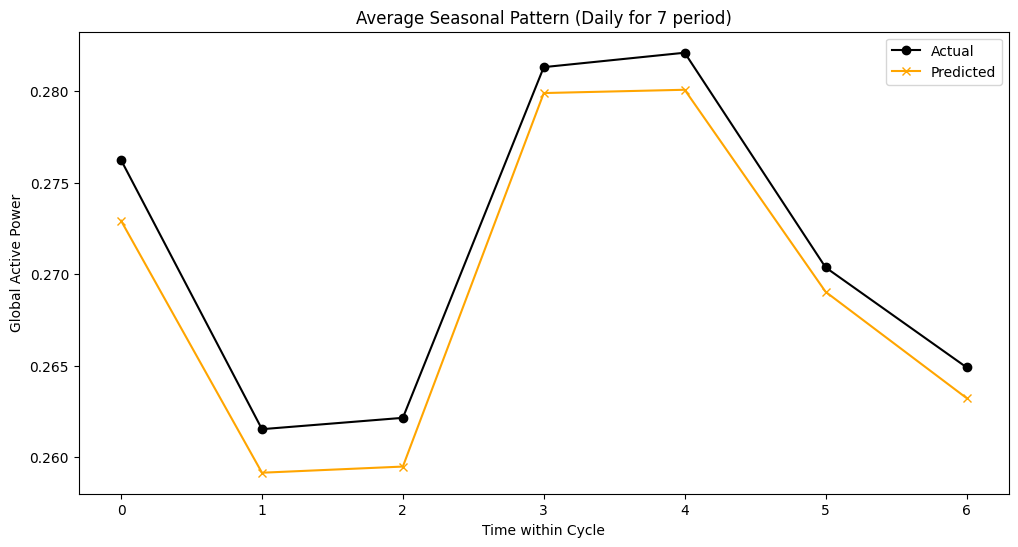

In [ ]:
plot_seasonal_patterns(y_test, y_pred_rf, 7, freq)
#plot_seasonal_patterns(y_test, y_pred_rf, 168, freq)

## Comparison of Results

In [ ]:
# Comparison of Results
results_df = pd.DataFrame(results)
print("Comparisons of Baseline Models: \n")
print(results_df)

Comparisons of Baseline Models: 

                         Model Frequency       MSE       MAE      RMSE  \
0               Naive Forecast    Minute  0.003380  0.016722  0.058141   
1   Multiple Linear Regression    Minute  0.000390  0.010255  0.019748   
2      Random Forest Regressor    Minute  0.000096  0.006510  0.009816   
3               Naive Forecast    Hourly  0.015023  0.079939  0.122567   
4                       SARIMA    Hourly  0.023680  0.117252  0.153883   
5                 Holt-Winters    Hourly  0.029420  0.141475  0.171524   
6   Multiple Linear Regression    Hourly  0.000063  0.004634  0.007914   
7      Random Forest Regressor    Hourly  0.000027  0.003058  0.005192   
8               Naive Forecast     Daily  0.008410  0.065290  0.091705   
9                       SARIMA     Daily  0.066217  0.231593  0.257327   
10                Holt-Winters     Daily  0.021640  0.117954  0.147105   
11  Multiple Linear Regression     Daily  0.000014  0.002793  0.003675   
12  

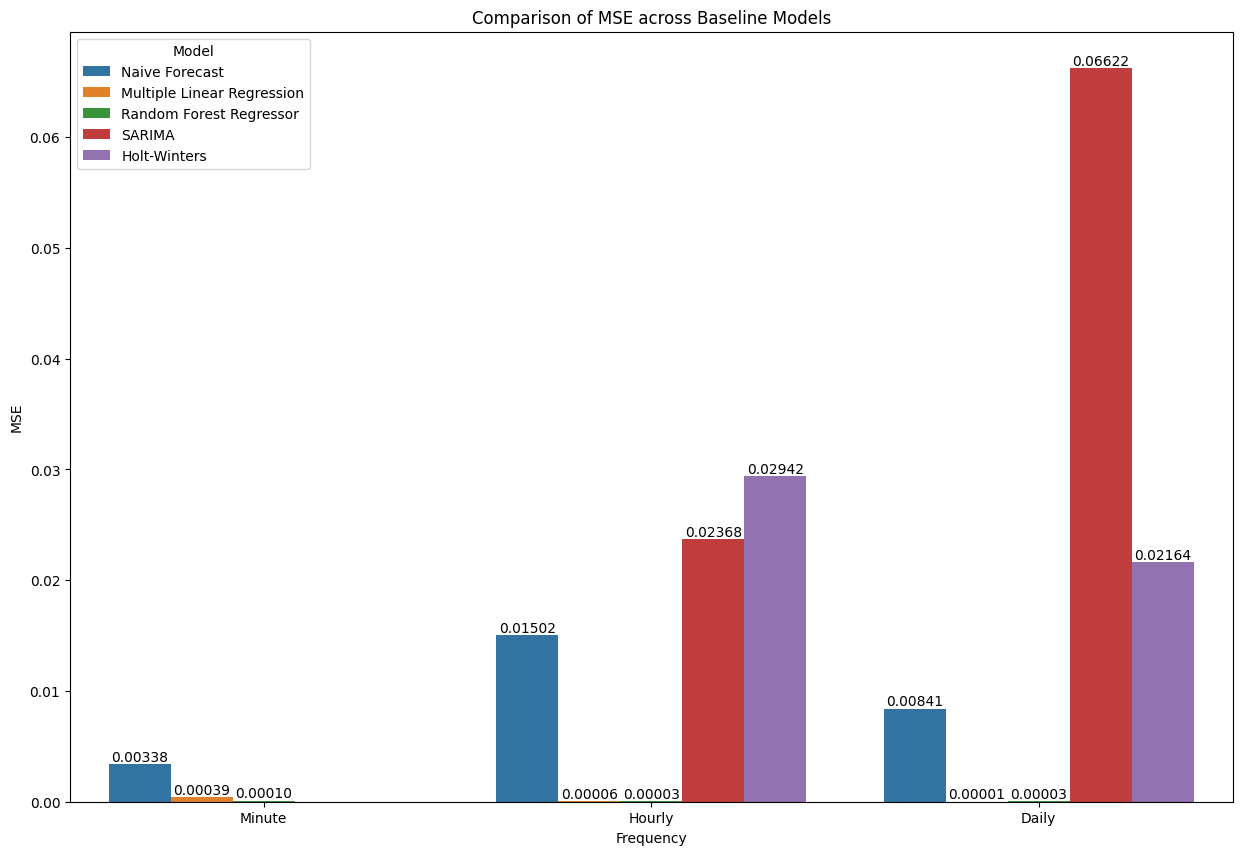

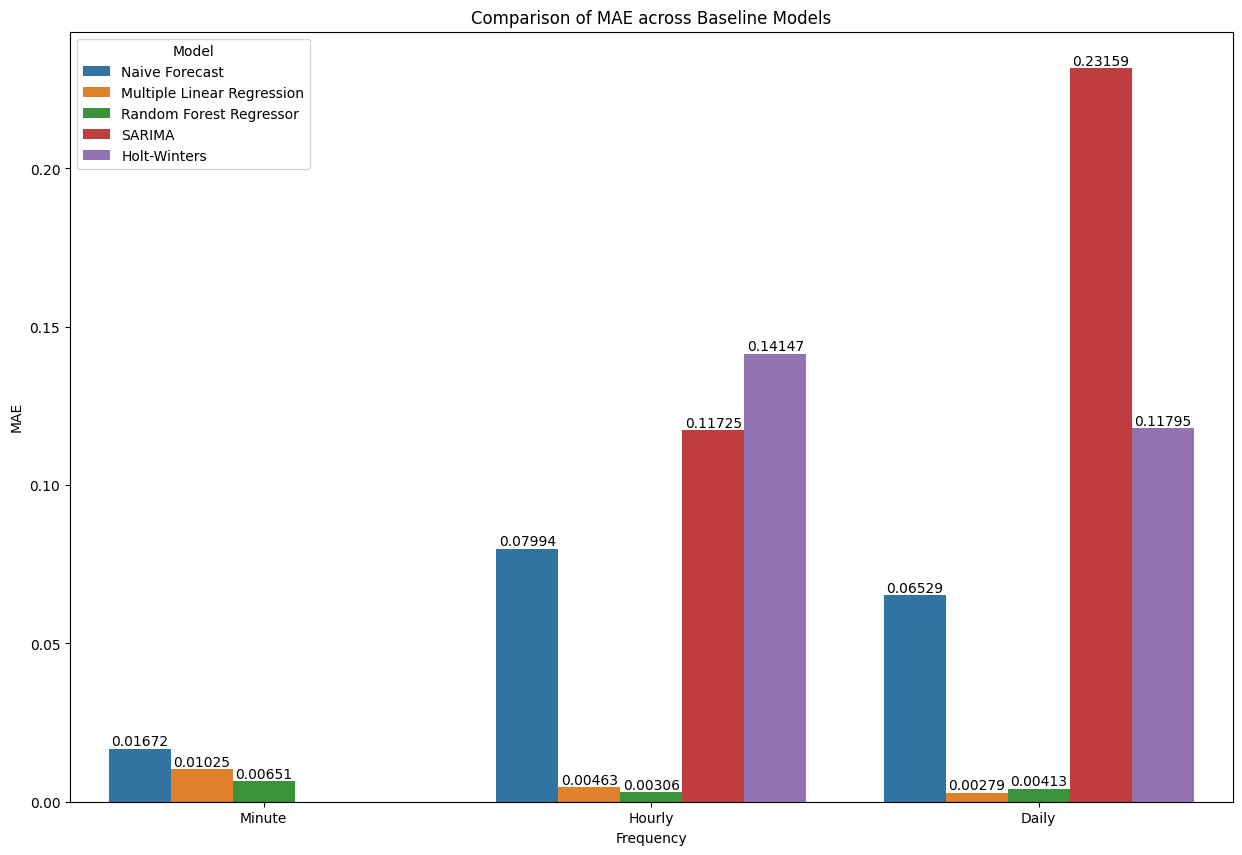

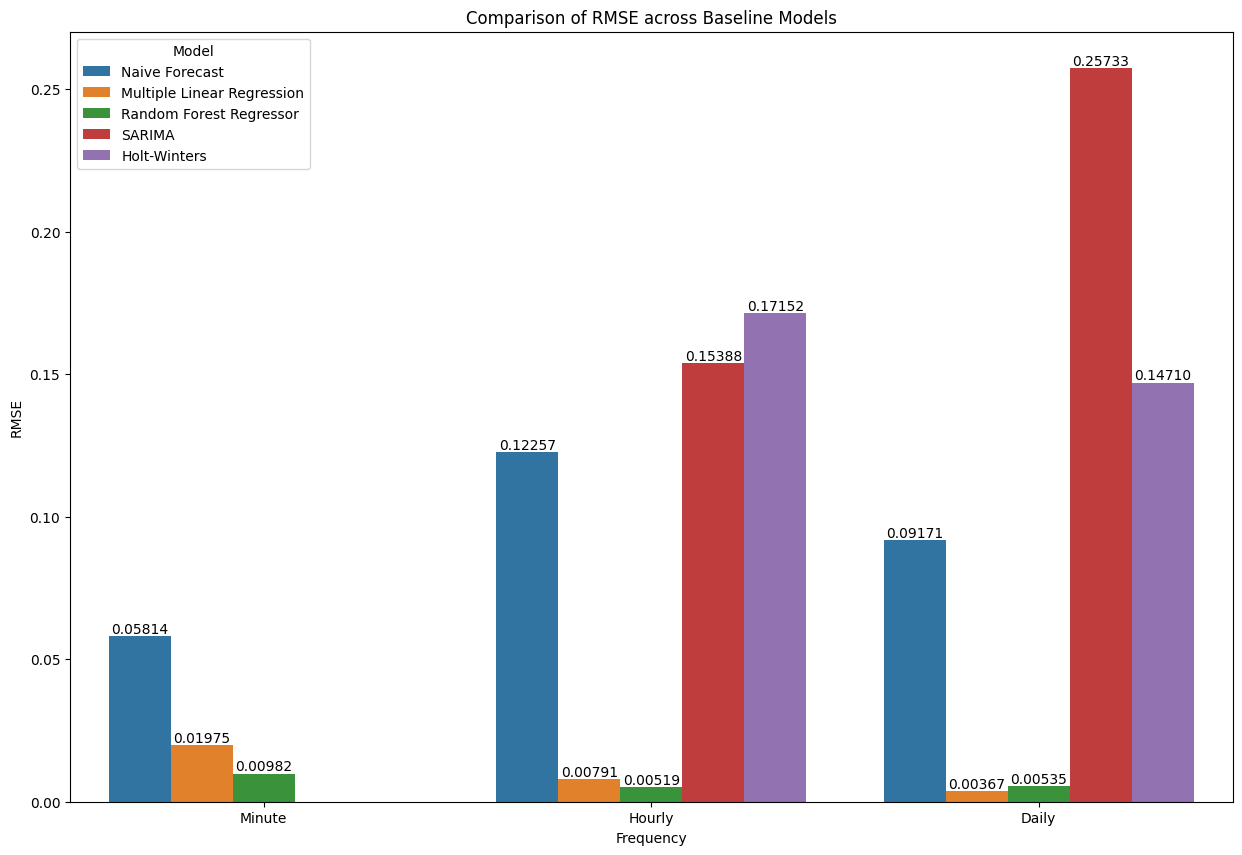

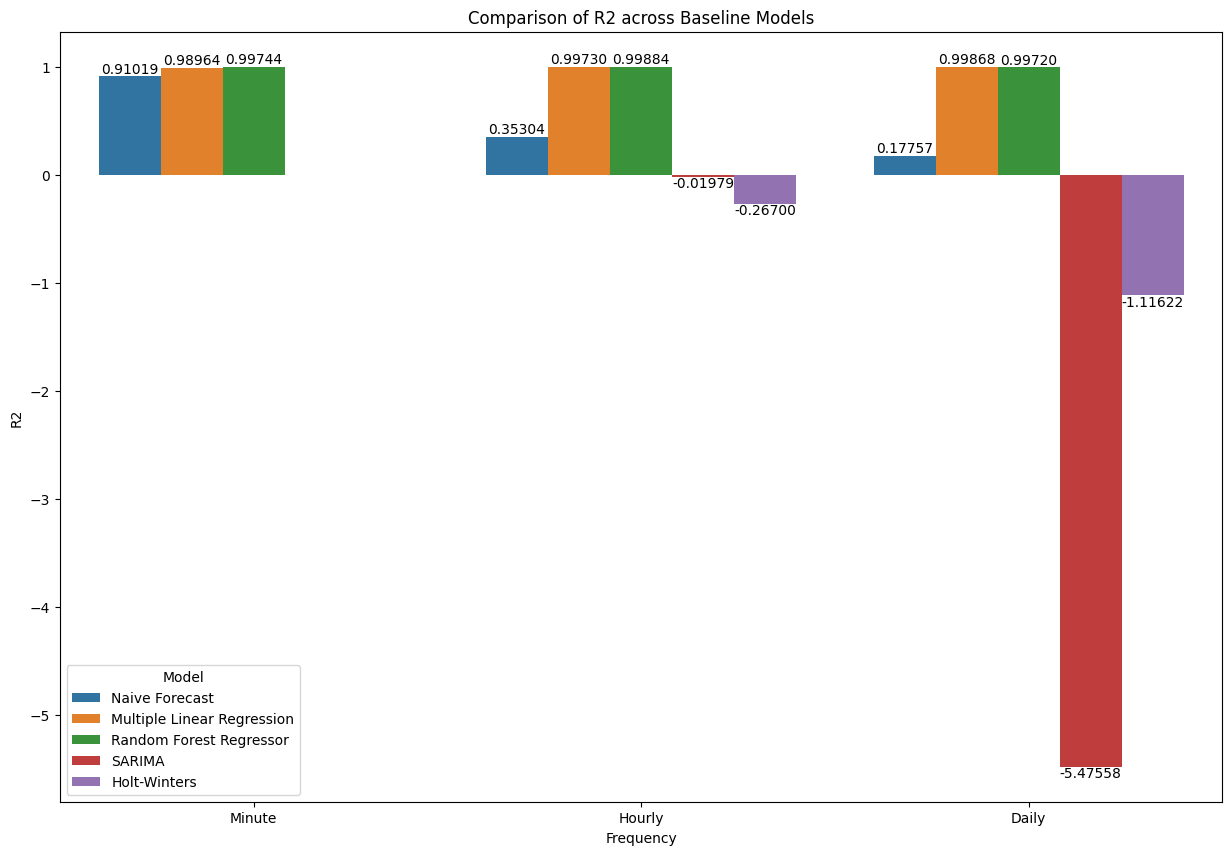

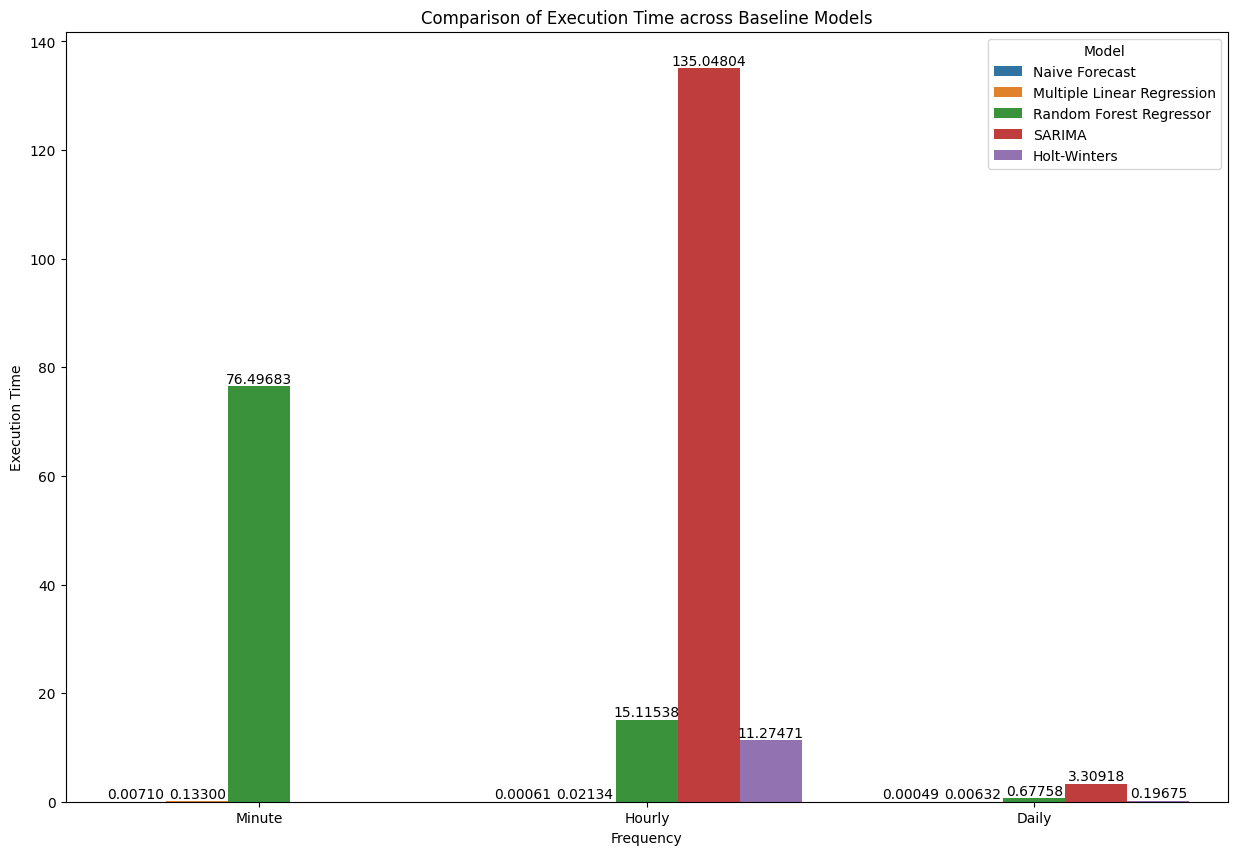

In [ ]:
# Bar Plots of metrics across models

metrics_col = ["MSE", "MAE", "RMSE", "R2", "Execution Time"]
for col in metrics_col:
  plt.figure(figsize=(15,10))
  ax = sns.barplot(data=results_df, x="Frequency", y=col, hue="Model")
  plt.title(f"Comparison of {col} across Baseline Models")
  plt.xlabel("Frequency")
  plt.ylabel(col)

  # Adding values on top of the bars
  for container in ax.containers:
      ax.bar_label(container, fmt='%.5f')

  plt.show()